In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import statsmodels.api as sm

ARIMA model starts here

In [15]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [16]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [17]:
df.columns = ['Month','Milk']

In [19]:
#df.drop(168, axis=0, inplace=True)
df.tail()

,Month,Milk
163,1975-08,858.0
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


In [20]:
df['Month'] = pd.to_datetime(df['Month'])

In [21]:
df.set_index('Month', inplace=True)

In [22]:
df.head()

,Milk
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


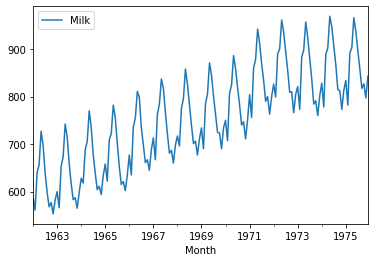

In [25]:
df.plot()

In [27]:
timeseries = df['Milk']
type(timeseries)

pandas.core.series.Series

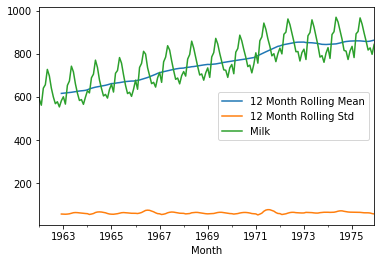

In [28]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

<Figure size 432x288 with 0 Axes>

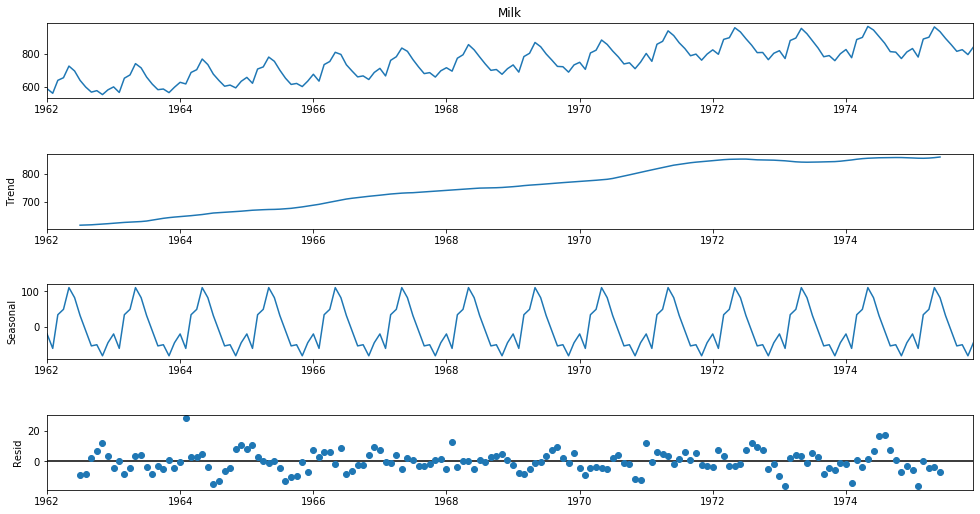

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk'], period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [34]:
from statsmodels.tsa.stattools import adfuller

In [35]:
result = adfuller(df['Milk'])

In [37]:
def adf_check(time_series):
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypo, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypo, time series has a unit root and is non-stationary ")

In [39]:
df['Milk First Difference'] = df['Milk'] - df['Milk'].shift(1)

In [40]:
adf_check(df['Milk First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0549955586530704
p-value : 0.030068004001785647
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypo, reject the null hypothesis. Data has no unit root and is stationary


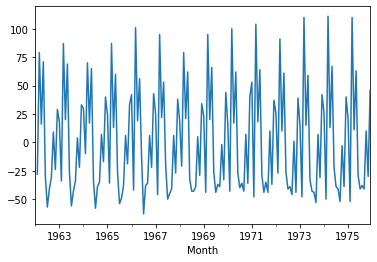

In [41]:
df['Milk First Difference'].plot()

In [42]:
df['Milk Second Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(1)

In [43]:
adf_check(df['Milk Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -14.327873645603301
p-value : 1.1126989332084581e-26
#Lags Used : 11
Number of Observations Used : 154
strong evidence against the null hypo, reject the null hypothesis. Data has no unit root and is stationary


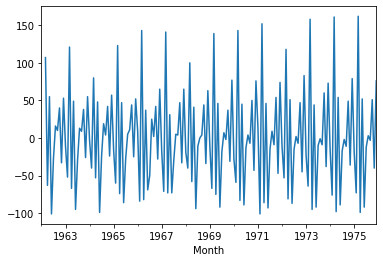

In [44]:
df['Milk Second Difference'].plot()

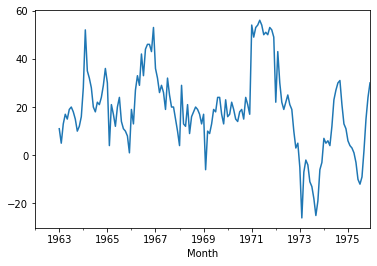

In [46]:
df['seasonal_diff'] = df['Milk'] - df['Milk'].shift(12)
df['seasonal_diff'].plot()

In [47]:
# Seasonal Difference by itself was not enough!
adf_check(df['seasonal_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.335419314359398
p-value : 0.1607988052771135
#Lags Used : 12
Number of Observations Used : 143
weak evidence against null hypo, time series has a unit root and is non-stationary 


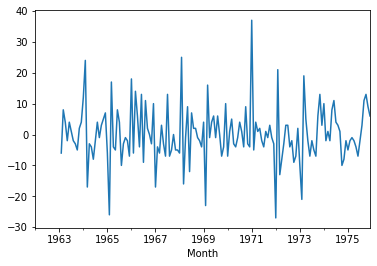

In [48]:
df['seasonal_first_diff'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['seasonal_first_diff'].plot()

In [49]:
adf_check(df['seasonal_first_diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921984
p-value : 1.8654234318788342e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypo, reject the null hypothesis. Data has no unit root and is stationary


In [50]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

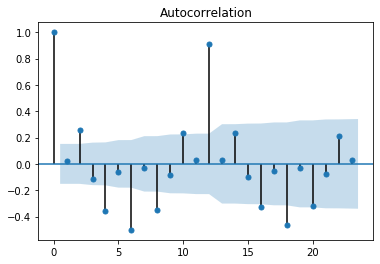

In [52]:
fig_first = plot_acf(df["Milk First Difference"].dropna())

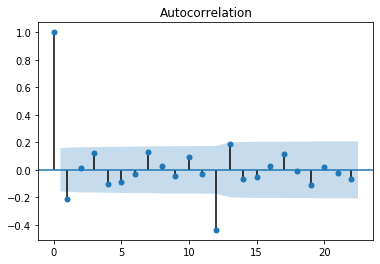

In [54]:
fig_seasonal_first = plot_acf(df["seasonal_first_diff"].dropna())

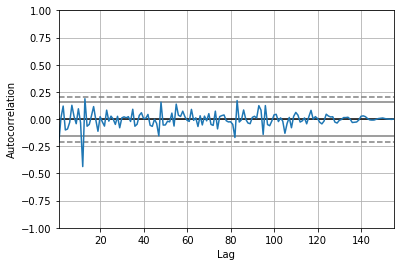

In [55]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['seasonal_first_diff'].dropna())

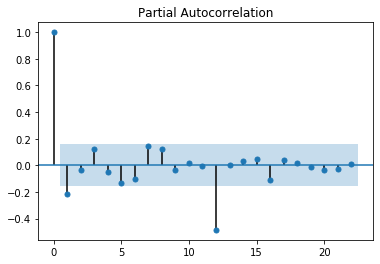

In [57]:
result = plot_pacf(df["seasonal_first_diff"].dropna())

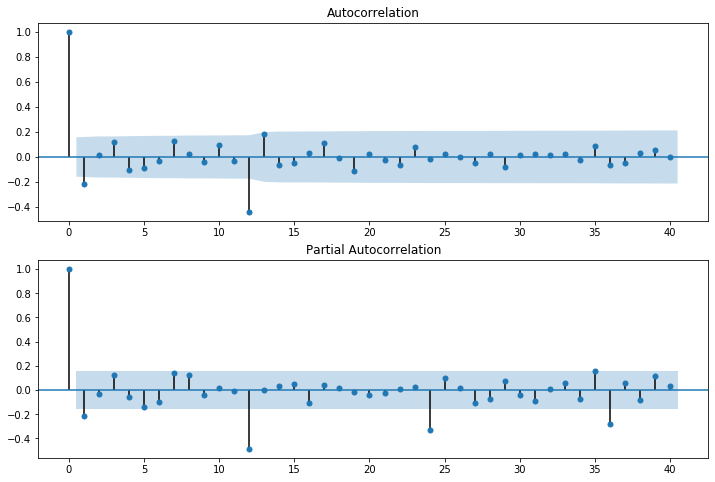

In [58]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['seasonal_first_diff'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['seasonal_first_diff'].iloc[13:], lags=40, ax=ax2)

In [59]:
from statsmodels.tsa.arima_model import ARIMA

In [61]:
#help(ARIMA)

In [95]:
model = sm.tsa.statespace.SARIMAX(df['Milk'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

C:\Users\rites\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\rites\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                 Milk   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Thu, 11 Jun 2020   AIC                           1074.131
Time:                                      22:34:44   BIC                           1083.261
Sample:                                  01-01-1962   HQIC                          1077.839
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.58

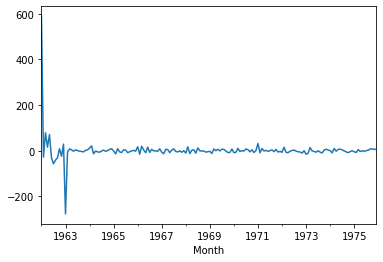

In [96]:
results.resid.plot()

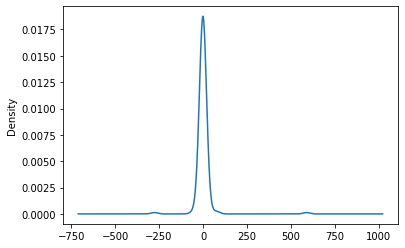

In [101]:
results.resid.plot(kind='kde')

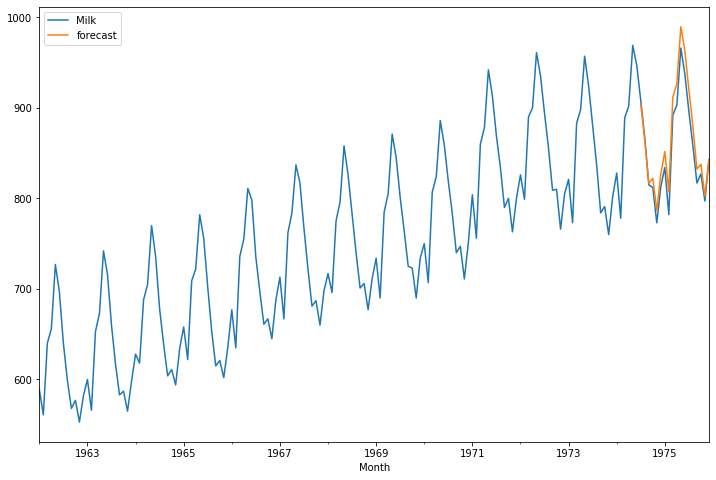

In [103]:
df['forecast'] = results.predict(start = 150, end= 168, dynamic= True)  
df[['Milk','forecast']].plot(figsize=(12,8))

In [104]:
df.tail()

,Milk,Milk First Difference,Milk Second Difference,seasonal_diff,seasonal_first_diff,forecast
Month,,,,,,
1975-08-01,858.0,-38.0,3.0,-9.0,3.0,879.668974
1975-09-01,817.0,-41.0,-3.0,2.0,11.0,832.328554
1975-10-01,827.0,10.0,51.0,15.0,13.0,837.722250
1975-11-01,797.0,-30.0,-40.0,24.0,9.0,802.452736
1975-12-01,843.0,46.0,76.0,30.0,6.0,842.499870


In [105]:
from pandas.tseries.offsets import DateOffset

In [116]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24) ]

In [117]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [121]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [122]:
future_df = pd.concat([df,future_dates_df])

In [123]:
future_df.head()

,Milk,Milk First Difference,Milk Second Difference,seasonal_diff,seasonal_first_diff,forecast
1962-01-01,589.0,NaN,NaN,NaN,NaN,NaN
1962-02-01,561.0,-28.0,NaN,NaN,NaN,NaN
1962-03-01,640.0,79.0,107.0,NaN,NaN,NaN
1962-04-01,656.0,16.0,-63.0,NaN,NaN,NaN
1962-05-01,727.0,71.0,55.0,NaN,NaN,NaN


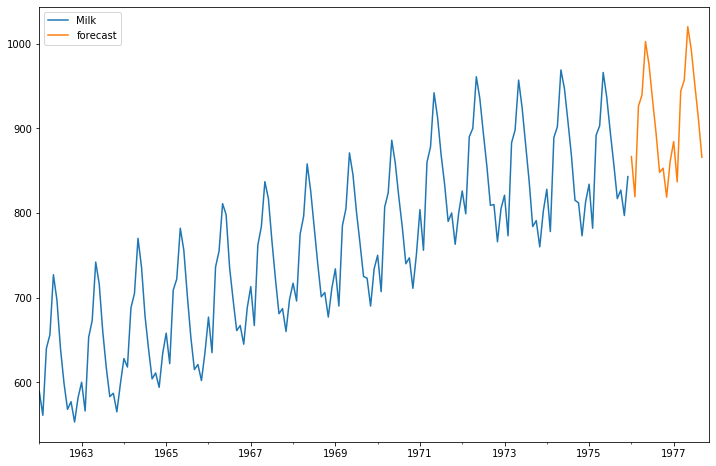

In [129]:
future_df['forecast'] = results.predict(start = 168, end = 188, dynamic= True)  
future_df[['Milk', 'forecast']].plot(figsize=(12, 8)) 